In [1]:
# ! git clone https://github.com/CodeArchitecture/FinRL.git

In [2]:
# import os
# os.chdir('/kaggle/working/FinRL')
# print(os.getcwd())

In [3]:
! pip install -r requirements.txt

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

# import sys
# sys.path.append("../FinRL")

import itertools

d:\Anaconda\envs\fin\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [5]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [6]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [7]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-03-01'

In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [9]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [10]:
df.shape

(97013, 8)

In [11]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.505281,493729600,AAPL,0
1,2010-01-04,56.630001,57.869999,56.560001,42.888958,5277400,AMGN,0
2,2010-01-04,40.810001,41.099998,40.389999,33.675976,6894300,AXP,0
3,2010-01-04,55.720001,56.389999,54.799999,43.777561,6186700,BA,0
4,2010-01-04,57.650002,59.189999,57.509998,41.156906,7325600,CAT,0


In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3310, 8)
Successfully added vix
Successfully added turbulence index


In [13]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [14]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)
processed_full.to_csv('processed.csv')

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.505281,493729600.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,6.505281,6.505281,20.040001,0.0
1,2010-01-04,AMGN,56.630001,57.869999,56.560001,42.888958,5277400.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,42.888958,42.888958,20.040001,0.0
2,2010-01-04,AXP,40.810001,41.099998,40.389999,33.675976,6894300.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,33.675976,33.675976,20.040001,0.0
3,2010-01-04,BA,55.720001,56.389999,54.799999,43.777561,6186700.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,43.777561,43.777561,20.040001,0.0
4,2010-01-04,CAT,57.650002,59.189999,57.509998,41.156906,7325600.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,41.156906,41.156906,20.040001,0.0
5,2010-01-04,CRM,18.652500,18.882500,18.547501,18.705000,7906000.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,18.705000,18.705000,20.040001,0.0
6,2010-01-04,CSCO,24.110001,24.840000,24.010000,17.394133,59853700.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,17.394133,17.394133,20.040001,0.0
7,2010-01-04,CVX,78.199997,79.199997,78.160004,46.851871,10173800.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,46.851871,46.851871,20.040001,0.0
8,2010-01-04,DIS,32.500000,32.750000,31.870001,27.933920,13700400.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,27.933920,27.933920,20.040001,0.0
9,2010-01-04,GS,170.050003,174.250000,169.509995,139.862793,9135000.0,0.0,0.0,6.526807,6.495,100.0,66.666667,100.0,139.862793,139.862793,20.040001,0.0


In [16]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

85753
10237


In [17]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2956,2021-09-30,UNH,401.489990,403.489990,390.459991,383.180176,3779900.0,3.0,-4.349257,419.212271,386.863769,40.895389,-222.938187,41.980385,405.947466,405.438420,23.139999,24.871921
2956,2021-09-30,V,227.580002,228.789993,222.630005,220.257767,7128500.0,3.0,-1.538726,228.639275,216.529596,44.078991,-54.614540,19.569853,224.777288,231.479428,23.139999,24.871921
2956,2021-09-30,VZ,54.500000,54.509998,54.000000,49.822678,18736600.0,3.0,-0.237534,50.960816,49.550737,41.824899,-102.899161,21.682953,50.425972,50.960237,23.139999,24.871921
2956,2021-09-30,WBA,48.790001,48.930000,46.919998,43.957287,6449400.0,3.0,-0.253540,48.531809,43.597246,44.613722,-107.390154,0.941150,45.886550,44.857786,23.139999,24.871921
2956,2021-09-30,WMT,140.639999,141.729996,139.250000,136.114777,7485900.0,3.0,-1.554835,146.155114,135.633137,40.165833,-151.542717,45.466733,142.345313,141.246727,23.139999,24.871921


In [18]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.404282,94639600.0,4.0,-1.703487,155.382847,137.132189,46.927765,-142.190081,41.749873,147.171800,146.269416,21.1,120.123687
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,203.845901,2629400.0,4.0,-3.097330,212.767988,199.379585,40.408569,-96.756836,36.189244,208.480832,217.103344,21.1,120.123687
0,2021-10-01,AXP,168.500000,175.119995,168.479996,170.695419,3956000.0,4.0,2.281750,174.864270,149.785742,56.265120,117.565686,15.667511,161.812906,164.064442,21.1,120.123687
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.123687
0,2021-10-01,CAT,192.899994,195.869995,191.240005,187.928040,3695500.0,4.0,-3.640322,205.735911,181.432781,41.999435,-112.087750,36.203176,196.993865,200.522105,21.1,120.123687


In [19]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [20]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [21]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [22]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [23]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

# TIMESTEPS = [100,100,100,100,100]
TIMESTEPS = [50000,50000,50000,50000,50000]

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [24]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [25]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=TIMESTEPS[0]) if if_using_a2c else None

### Agent 2: DDPG

In [26]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [27]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=TIMESTEPS[1]) if if_using_ddpg else None

### Agent 3: PPO

In [28]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [29]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=TIMESTEPS[2]) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 32        |
|    iterations      | 1         |
|    time_elapsed    | 63        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.9986378 |
----------------------------------


### Agent 4: TD3

In [30]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [31]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=TIMESTEPS[3]) if if_using_td3 else None

### Agent 5: SAC

In [32]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [33]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=TIMESTEPS[4]) if if_using_sac else None

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [34]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [35]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [36]:
insample_risk_indicator.vix.quantile(0.9)

26.47999954223633

In [37]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean       34.139590
std        43.879104
min         0.000000
25%        14.613387
50%        23.644707
75%        38.292695
max       652.505693
Name: turbulence, dtype: float64

In [38]:
insample_risk_indicator.turbulence.quantile(0.9)

66.08537738749267

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [39]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = insample_risk_indicator.turbulence.quantile(0.9),risk_indicator_col='turbulence', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [40]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,141.404282,94639600.0,4.0,-1.703487,155.382847,137.132189,46.927765,-142.190081,41.749873,147.171800,146.269416,21.1,120.123687
0,2021-10-01,AMGN,213.589996,214.610001,210.800003,203.845901,2629400.0,4.0,-3.097330,212.767988,199.379585,40.408569,-96.756836,36.189244,208.480832,217.103344,21.1,120.123687
0,2021-10-01,AXP,168.500000,175.119995,168.479996,170.695419,3956000.0,4.0,2.281750,174.864270,149.785742,56.265120,117.565686,15.667511,161.812906,164.064442,21.1,120.123687
0,2021-10-01,BA,222.850006,226.720001,220.600006,226.000000,9113600.0,4.0,0.730320,226.909442,205.727561,51.614047,116.649440,2.027170,217.175334,221.968500,21.1,120.123687
0,2021-10-01,CAT,192.899994,195.869995,191.240005,187.928040,3695500.0,4.0,-3.640322,205.735911,181.432781,41.999435,-112.087750,36.203176,196.993865,200.522105,21.1,120.123687


In [41]:
trained_moedl = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [42]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [43]:
trained_moedl = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [44]:
trained_moedl = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [45]:
trained_moedl = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_moedl, 
    environment = e_trade_gym)

hit end!


In [46]:
df_account_value_a2c.shape

(353, 2)

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [47]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
df_account_value_a2c.to_csv("results/df_account_value_a2c.csv")
df_account_value_ddpg.to_csv("results/df_account_value_ddpg.csv")
df_account_value_td3.to_csv("results/df_account_value_td3.csv")
df_account_value_ppo.to_csv("results/df_account_value_ppo.csv")
df_account_value_sac.to_csv("results/df_account_value_sac.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI", 
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_a2c['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("results/df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("results/df_dji+.csv")

result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
# result = pd.merge(result, MVO_result, left_index=True, right_index=True)
result = pd.merge(result, df_dji, left_index=True, right_index=True)
result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'dji']

print("result: ", result)
result.to_csv("results/result.csv")

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (354, 8)
result:                       a2c          ddpg           td3           ppo  \
date                                                                 
2021-10-01  1.000000e+06  1.000000e+06  1.000000e+06  1.000000e+06   
2021-10-04  9.985765e+05  9.965331e+05  9.958541e+05  9.999248e+05   
2021-10-05  1.001905e+06  1.002459e+06  1.002453e+06  1.000089e+06   
2021-10-06  1.003111e+06  1.007538e+06  1.005955e+06  1.000171e+06   
2021-10-07  1.011915e+06  1.017928e+06  1.015398e+06  1.000423e+06   
...                  ...           ...           ...           ...   
2023-02-21  9.849470e+05  8.733995e+05  9.006111e+05  9.891502e+05   
2023-02-22  9.839412e+05  8.706863e+05  8.993816e+05  9.889180e+05   
2023-02-23  9.887902e+05  8.731826e+05  9.039833e+05  9.893237e+05   
2023-02-24  9.755412e+05  8.667151e+05  8.954663e+05  9.888712e+05   
2023-02-

d:\Anaconda\envs\fin\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8724\3948796361.py:27: FutureWarning: Passing 'suffixes' which cause duplicate columns {'account_value_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_8724\3948796361.py:30: FutureWarning: Passing 'suffixes' which cause duplicate columns {'account_value_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = pd.merge(result, df_dji, left_index=True, right_index=True)


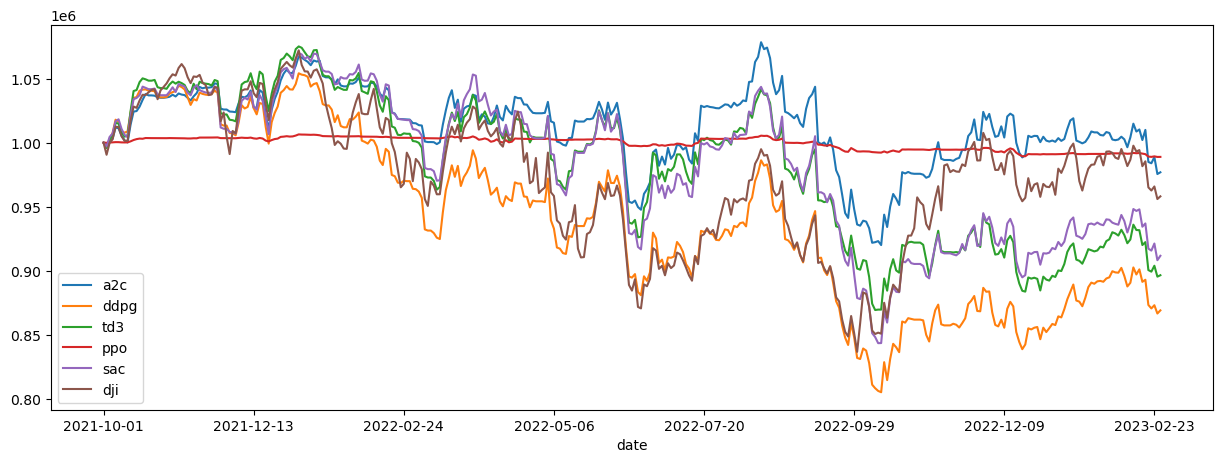

In [58]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
# fig = plt.figure()
fig = result.plot()
# plt.plot(result)
fig.get_figure().savefig('results/backtest.png')

In [53]:
pd.DataFrame(backtest_stats(account_value=df_account_value_a2c)).to_csv('results/a2c_perf.csv')
pd.DataFrame(backtest_stats(account_value=df_account_value_ddpg)).to_csv('results/ddpg_perf.csv')
pd.DataFrame(backtest_stats(account_value=df_account_value_td3)).to_csv('results/td3_perf.csv')
pd.DataFrame(backtest_stats(account_value=df_account_value_ppo)).to_csv('results/ppo_perf.csv')
pd.DataFrame(backtest_stats(account_value=df_account_value_sac)).to_csv('results/sac_perf.csv')

Annual return         -0.016552
Cumulative returns    -0.023108
Annual volatility      0.129391
Sharpe ratio          -0.064714
Calmar ratio          -0.112787
Stability              0.260002
Max drawdown          -0.146752
Omega ratio            0.987478
Sortino ratio         -0.088894
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.900032
Daily value at risk   -0.016335
dtype: float64


d:\Anaconda\envs\fin\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [49]:
import shutil
folder_name = 'results'
zip_file_name = 'results'
shutil.make_archive(zip_file_name, 'zip', folder_name)

'c:\\Users\\ThinkPad\\Desktop\\code\\FinRL\\results.zip'